In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.utils.mem import *

In [5]:
from pathlib import Path

## Config

In [6]:
path = Path('../data')
path_img = path/'train_images'
path_train_csv = path/'train.csv'

In [7]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 7401MB of GPU RAM free


## Data

In [8]:
train_df = pd.read_csv(path_train_csv)

In [9]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [10]:
d = train_df.set_index('id_code').to_dict()['diagnosis']

In [11]:
src = (ImageList.from_df(train_df, path, ['id_code'], folder='train_images', suffix='.png')
       .split_by_rand_pct(0.2)
      .label_from_func(lambda i: d[Path(i).stem]))

In [12]:
# TODO - padding?, bigger size?
data = src.transform(size=256).databunch(bs=bs).normalize(imagenet_stats)

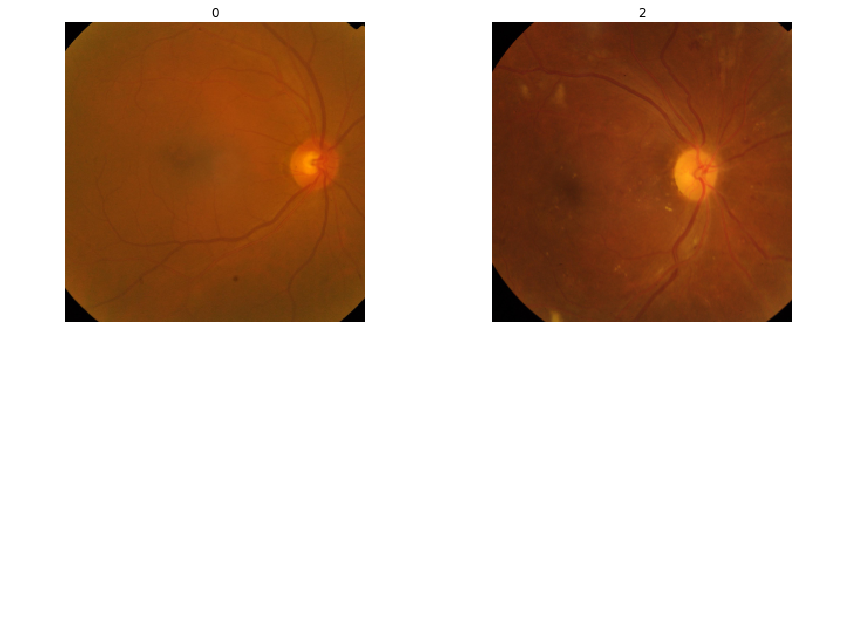

In [13]:
data.show_batch(rows=3, figsize=(12,9))

In [14]:
data.save('image_data_256.pkl')

In [15]:
data = load_data(path, file='image_data_256.pkl')

In [16]:
# Smaller architecture
arch = models.resnet50

In [17]:
kappa = KappaScore()
kappa.weights = "quadratic"
learn = cnn_learner(data, arch, metrics=kappa)

In [18]:
learn.lr_find()
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 6.63 GiB already allocated; 12.19 MiB free; 15.64 MiB cached)

In [14]:
lr = 1E-3

In [16]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,kappa_score,time
0,1.272889,1.011517,0.719911,01:41
1,0.874433,0.931132,0.763068,01:43


In [18]:
learn.save('stage-1-rn50')

In [ ]:
learn.load('stage-1-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.save('stage-2-rn50')

In [19]:
learn.export()

In [20]:
test_src = ImageList.from_folder(path/'test_images')

In [21]:
learn = load_learner(path, test=test_src)

In [22]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
idcodes = [x.stem for x in (path/'test_images').iterdir()]
predss = pd.Series(preds.argmax(dim=1), index=idcodes)
sub = pd.DataFrame(data=predss, columns=['diagnosis'])
sub.index.name = 'id_code'

In [64]:
from fastai.

In [ ]:
fastai.load